In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
import matplotlib
import matplotlib.pyplot as plt

In [2]:
plt.style.use('ggplot')
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

## Strong Wells Set

### Import Data

In [7]:
path = ''
alldataSWS = pd.read_csv(path+'Xy_Neigh10Add10Strong_rgrs4_tvdss.csv', low_memory=False)
alldataSWS.drop(['TVD'], axis=1, inplace=True)

In [8]:
# Frequency encoding
def freq_encode(df, feat): 
    '''Frequency encoding for 1 categorical variable'''
    cat_size = df.groupby(feat).size()
    freq = cat_size/df.shape[0]    
    return df[feat].map(freq)

for var in alldataSWS.columns[alldataSWS.dtypes=='object']: 
    if var not in ['Formation', 'Field', 'Pool', 'FFP', 'WellProfile']: 
        alldataSWS[var] = freq_encode(alldataSWS, var)
    else: 
        alldataSWS[var] = alldataSWS[var].astype('category')

In [9]:
X_trainSWS = alldataSWS[alldataSWS.TVDSS.isnull()==False]
X_testSWS = alldataSWS[alldataSWS.TVDSS.isnull()]

In [10]:
X_trainSWS = X_trainSWS[X_trainSWS.Formation!='Cardium']

y_trainSWS = X_trainSWS[['EPAssetsId', 'TVDSS']]
X_trainSWS = X_trainSWS.drop(['TVDSS'], axis=1)

print(X_trainSWS.shape)
print(y_trainSWS.shape)

X_testSWS = X_testSWS.drop(['TVDSS'], axis=1)

(4435, 142)
(4435, 2)


### LGBM

#### Hyperparameters Tuning

In [12]:
# RS1
LGBM_SWS = LGBMRegressor(random_state=99, objective='rmse', silent='False')
grid = {'learning_rate': [0.05, 0.1, 0.2, 0.4], 
        'num_iterations': [50, 100, 200, 400], 
        'bagging_fraction': [0.4, 0.6, 0.8, 1], 
        'feature_fraction': [0.4, 0.6, 0.8, 1], 
        'max_depth': [5, 10, 20, 40]}
rs = RandomizedSearchCV(estimator=LGBM_SWS, param_distributions=grid, 
                        scoring='neg_root_mean_squared_error', n_iter=250, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=55), 
                        random_state=99, n_jobs=5, verbose=5)
rs.fit(X_trainSWS, y_trainSWS.TVDSS)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   13.1s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:   47.0s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  8.6min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 11.8min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 15.0min
[Parallel(n_jobs=5)]: Done 1250 out of 1250 | elapsed: 17.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective='rmse', rando...
                                           subsample_freq=0),
                   iid='deprecated', n_iter=250, n_jobs=5,
                   param_distributions={'bagging_fraction': [0.4, 0.6, 0.8, 1],
   

In [13]:
pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_iterations,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
188,6.236009,0.087316,0.106,8.000028e-03,400,20,0.1,0.4,0.6,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-12.173414,-13.545945,-9.620568,-13.167698,-12.353966,-12.172318,1.372739,1
196,6.452626,0.106714,0.102,1.326657e-02,400,20,0.1,0.4,0.4,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-12.173414,-13.545945,-9.620568,-13.167698,-12.353966,-12.172318,1.372739,1
66,6.560009,0.050200,0.106,4.898975e-03,400,20,0.1,0.4,0.8,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-12.173414,-13.545945,-9.620568,-13.167698,-12.353966,-12.172318,1.372739,1
18,6.312009,0.068527,0.108,9.798037e-03,400,40,0.05,0.4,0.6,"{'num_iterations': 400, 'max_depth': 40, 'lear...",-12.103412,-13.646538,-9.543928,-13.423860,-12.232005,-12.189949,1.459786,4
109,6.124009,0.074458,0.108,3.999901e-03,400,20,0.05,0.4,0.6,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-12.062138,-13.659594,-9.563036,-13.434716,-12.253112,-12.194519,1.458094,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.092001,0.045782,0.044,4.899092e-03,50,5,0.05,0.8,0.6,"{'num_iterations': 50, 'max_depth': 5, 'learni...",-63.674433,-66.518228,-61.567768,-64.657841,-64.994378,-64.282530,1.636194,246
228,1.294002,0.013565,0.036,4.899072e-03,50,5,0.05,1,1,"{'num_iterations': 50, 'max_depth': 5, 'learni...",-63.703173,-66.504698,-61.590962,-64.548752,-65.072605,-64.284038,1.625626,247
138,1.492402,0.027405,0.046,4.898955e-03,50,10,0.05,0.8,0.4,"{'num_iterations': 50, 'max_depth': 10, 'learn...",-63.469674,-66.374842,-61.742299,-64.583500,-65.605508,-64.355164,1.631303,248
170,1.410002,0.030332,0.040,1.168008e-07,50,40,0.05,0.8,0.6,"{'num_iterations': 50, 'max_depth': 40, 'learn...",-63.469674,-66.374842,-61.742299,-64.583500,-65.605508,-64.355164,1.631303,248


In [14]:
rs.best_params_

{'num_iterations': 400,
 'max_depth': 20,
 'learning_rate': 0.1,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.8}

In [15]:
# RS2
LGBM_SWS = LGBMRegressor(random_state=99, objective='rmse', silent='False')
grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2], 
        'num_iterations': [200, 300, 400, 500], 
        'bagging_fraction': [0.7, 0.8, 0.9, 1], 
        'feature_fraction': [0.3, 0.4, 0.5, 0.6], 
        'max_depth': [15, 20, 25, 30]}
rs2 = RandomizedSearchCV(estimator=LGBM_SWS, param_distributions=grid, 
                        scoring='neg_root_mean_squared_error', n_iter=250, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=55), 
                        random_state=99, n_jobs=5, verbose=5)
rs2.fit(X_trainSWS, y_trainSWS.TVDSS)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   13.7s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  9.0min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 13.0min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 17.7min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 22.5min
[Parallel(n_jobs=5)]: Done 1250 out of 1250 | elapsed: 25.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
                   error_score=nan,
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective='rmse', rando...
                   iid='deprecated', n_iter=250, n_jobs=5,
                   param_distributions={'bagging_fraction': [0.7, 0.8, 0.9, 1],
                                        'feature_fraction': [0.3,

In [16]:
pd.DataFrame(rs2.cv_results_).sort_values('rank_test_score').iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_iterations,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
99,7.854011,0.078128,0.126,0.004899,500,20,0.1,0.4,0.8,"{'num_iterations': 500, 'max_depth': 20, 'lear...",-12.145911,-13.523066,-9.620382,-13.166953,-12.361130,-12.163488,1.368368,1
22,6.228009,0.069109,0.104,0.004899,400,20,0.1,0.4,0.7,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-12.173414,-13.545945,-9.620568,-13.167698,-12.353966,-12.172318,1.372739,2
184,4.724007,0.058515,0.094,0.012000,300,20,0.1,0.4,1,"{'num_iterations': 300, 'max_depth': 20, 'lear...",-12.198340,-13.570637,-9.623240,-13.162636,-12.344074,-12.179785,1.375771,3
194,4.736006,0.074458,0.088,0.013267,300,20,0.1,0.4,0.9,"{'num_iterations': 300, 'max_depth': 20, 'lear...",-12.198340,-13.570637,-9.623240,-13.162636,-12.344074,-12.179785,1.375771,3
131,7.520011,0.128375,0.126,0.010198,500,15,0.05,0.4,1,"{'num_iterations': 500, 'max_depth': 15, 'lear...",-12.102577,-13.593420,-9.564468,-13.467485,-12.176738,-12.180938,1.449302,5
172,4.570006,0.068411,0.090,0.006324,300,25,0.05,0.4,1,"{'num_iterations': 300, 'max_depth': 25, 'lear...",-12.096549,-13.702727,-9.494158,-13.410299,-12.209177,-12.182582,1.486867,6
50,4.284006,0.091564,0.088,0.011662,300,15,0.05,0.4,1,"{'num_iterations': 300, 'max_depth': 15, 'lear...",-12.115844,-13.705213,-9.535682,-13.438752,-12.129891,-12.185076,1.477135,7
80,3.148004,0.095792,0.070,0.010954,200,20,0.1,0.4,1,"{'num_iterations': 200, 'max_depth': 20, 'lear...",-12.206229,-13.645118,-9.617046,-13.182915,-12.281679,-12.186597,1.395131,8
222,3.092004,0.033106,0.070,0.006324,200,20,0.1,0.4,0.9,"{'num_iterations': 200, 'max_depth': 20, 'lear...",-12.206229,-13.645118,-9.617046,-13.182915,-12.281679,-12.186597,1.395131,8
114,3.180005,0.111893,0.072,0.009798,200,20,0.1,0.4,0.7,"{'num_iterations': 200, 'max_depth': 20, 'lear...",-12.206229,-13.645118,-9.617046,-13.182915,-12.281679,-12.186597,1.395131,8


In [17]:
rs2.best_params_

{'num_iterations': 500,
 'max_depth': 20,
 'learning_rate': 0.1,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.8}

#### Train

In [12]:
traintemp = pd.DataFrame()
testtemp = pd.DataFrame()
feat_im = pd.DataFrame(X_trainSWS.columns, columns=['Feature Id'])
for i, seed in enumerate(np.random.randint(low=0, high=2**32, size=10, dtype=np.int64)):
    LGBM = LGBMRegressor(num_iterations=500,
                         max_depth=20,
                         learning_rate=0.1,
                         feature_fraction=0.4,
                         bagging_fraction=0.8,                         
                         objective='rmse',
                         random_state=seed,
                         silent=False)
    LGBM.fit(X_trainSWS, y_trainSWS.TVDSS)
    traintemp['run'+str(i)] = np.squeeze(LGBM.predict(X_trainSWS))
    testtemp['run'+str(i)] = np.squeeze(LGBM.predict(X_testSWS))
    feat_im['run'+str(i)] = LGBM.feature_importances_

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



In [13]:
y_trSWS = X_trainSWS[['EPAssetsId']].copy(deep=True)
y_trSWS['pred'] = traintemp.mean(axis=1).values + X_trainSWS.KBElevation

y_predSWS = X_testSWS[['EPAssetsId']].copy(deep=True)
y_predSWS['pred'] = testtemp.mean(axis=1).values + X_testSWS.KBElevation

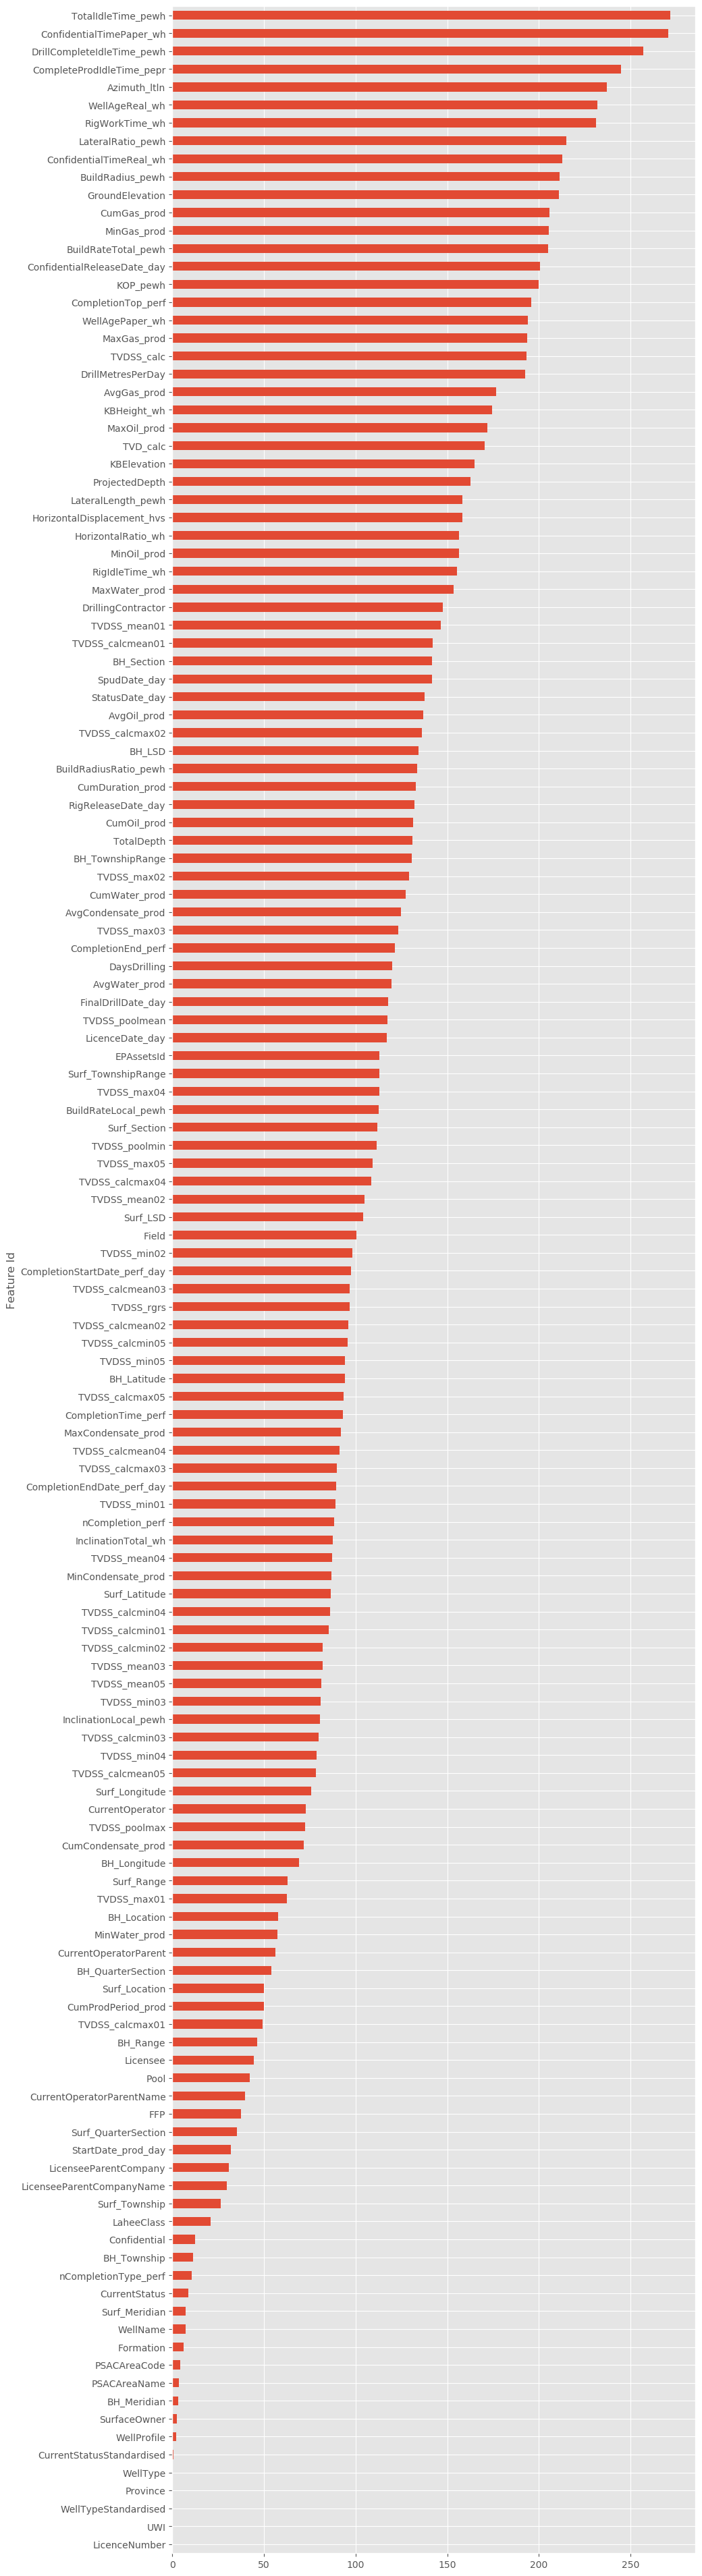

In [21]:
plt.figure(figsize=(10,50))
feat_im.set_index('Feature Id').mean(axis=1).sort_values(ascending=True).plot(kind='barh')

## Weak Wells Set

### Import Data

In [22]:
# path = '/gdrive/My Drive/Colab Notebooks/Untapped Energy - DUC/wholeset/'
path = ''
alldata = pd.read_csv(path+'Xy_Neigh10Add10Weak2.csv', low_memory=False)
alldataWWS = alldata[(alldata.Formation.isin(['Duvernay', 'Montney'])) |
                     ((alldata.Formation == 'Viking') & ((alldata.Pool == 'Temporary Commingled')|
                                                         (alldata.Field.str.contains('Miscellaneous'))))].reset_index(drop=True)

In [23]:
# Frequency encoding
for var in alldataWWS.columns[alldataWWS.dtypes=='object']: 
    if var not in ['Formation', 'Field', 'Pool', 'FFP', 'WellProfile']: 
        alldataWWS[var] = freq_encode(alldataWWS, var)
    else: 
        alldataWWS[var] = alldataWWS[var].astype('category')

In [24]:
X_trainWWS = alldataWWS[alldataWWS.TVD.isnull()==False]
X_testWWS = alldataWWS[alldataWWS.TVD.isnull()]

In [25]:
X_trainWWS = X_trainWWS[X_trainWWS.Formation!='Cardium']

y_trainWWS = X_trainWWS[['EPAssetsId', 'TVD']]
X_trainWWS = X_trainWWS.drop(['TVD'], axis=1)

print(X_trainWWS.shape)
print(y_trainWWS.shape)

X_testWWS = X_testWWS.drop(['TVD'], axis=1)

(2233, 970)
(2233, 2)


### LGBM

#### Hyperparameters Tuning

In [254]:
# RS1
LGBM_WWS = LGBMRegressor(random_state=99, objective='rmse', silent='False')
grid = {'learning_rate': [0.05, 0.1, 0.2, 0.4], 
        'num_iterations': [50, 100, 200, 400], 
        'bagging_fraction': [0.4, 0.6, 0.8, 1], 
        'feature_fraction': [0.4, 0.6, 0.8, 1], 
        'max_depth': [5, 10, 20, 40]}
rs = RandomizedSearchCV(estimator=LGBM_WWS, param_distributions=grid, 
                        scoring='neg_root_mean_squared_error', n_iter=250, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=55), 
                        random_state=99, n_jobs=5, verbose=5)
rs.fit(X_trainWWS, y_trainWWS.TVD)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:  4.5min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 24.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 61.8min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 83.5min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 106.4min
[Parallel(n_jobs=5)]: Done 1250 out of 1250 | elapsed: 123.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



RandomizedSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
                   estimator=LGBMRegressor(objective='rmse', random_state=99,
                                           silent='False'),
                   n_iter=250, n_jobs=5,
                   param_distributions={'bagging_fraction': [0.4, 0.6, 0.8, 1],
                                        'feature_fraction': [0.4, 0.6, 0.8, 1],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.4],
                                        'max_depth': [5, 10, 20, 40],
                                        'num_iterations': [50, 100, 200, 400]},
                   random_state=99, scoring='neg_root_mean_squared_error',
                   verbose=5)

In [255]:
pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_iterations,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,45.494202,0.427212,0.117607,0.004455,400,40,0.05,0.4,0.6,"{'num_iterations': 400, 'max_depth': 40, 'lear...",-42.580644,-37.659038,-47.429491,-32.669638,-41.094336,-40.286629,4.936764,1
66,52.170584,0.843029,0.151009,0.004427,400,20,0.1,0.4,0.8,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-40.832823,-37.480774,-48.287351,-33.450573,-41.507477,-40.311799,4.907172,2
196,48.402068,0.561228,0.126000,0.004899,400,20,0.1,0.4,0.4,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-40.832823,-37.480774,-48.287351,-33.450573,-41.507477,-40.311799,4.907172,2
188,48.058067,0.643628,0.130000,0.006325,400,20,0.1,0.4,0.6,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-40.832823,-37.480774,-48.287351,-33.450573,-41.507477,-40.311799,4.907172,2
109,51.308335,0.310221,0.135608,0.010557,400,20,0.05,0.4,0.6,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-42.533190,-37.804503,-47.597547,-32.663920,-41.095737,-40.338979,4.967981,5
205,47.130066,0.630271,0.132000,0.009798,400,40,0.1,0.4,0.6,"{'num_iterations': 400, 'max_depth': 40, 'lear...",-40.936152,-37.367083,-48.578317,-33.306893,-41.519640,-40.341617,5.058056,6
166,35.966050,0.904227,0.118000,0.004000,400,10,0.1,0.4,1,"{'num_iterations': 400, 'max_depth': 10, 'lear...",-40.975300,-37.654975,-48.643578,-33.063598,-41.443236,-40.356137,5.113203,7
221,25.354036,0.263105,0.098000,0.004000,200,40,0.1,0.4,1,"{'num_iterations': 200, 'max_depth': 40, 'lear...",-41.147982,-37.417493,-48.714284,-33.469492,-41.368450,-40.423540,5.050727,8
203,24.302034,0.164852,0.094000,0.004899,200,40,0.1,0.4,0.4,"{'num_iterations': 200, 'max_depth': 40, 'lear...",-41.147982,-37.417493,-48.714284,-33.469492,-41.368450,-40.423540,5.050727,8
133,38.378054,0.664693,0.116000,0.008000,400,10,0.05,0.4,0.8,"{'num_iterations': 400, 'max_depth': 10, 'lear...",-42.505922,-38.006944,-47.562991,-32.692423,-41.412496,-40.436155,4.937518,10


In [256]:
rs.best_params_

{'num_iterations': 400,
 'max_depth': 40,
 'learning_rate': 0.05,
 'feature_fraction': 0.4,
 'bagging_fraction': 0.6}

In [158]:
# RS2
LGBM_WWS = LGBMRegressor(random_state=99, objective='rmse', silent='False')
grid = {'learning_rate': [0.05, 0.1, 0.15, 0.2], 
        'num_iterations': [200, 300, 400, 500], 
        'bagging_fraction': [0.7, 0.8, 0.9, 1], 
        'feature_fraction': [0.3, 0.4, 0.5, 0.6], 
        'max_depth': [5, 10, 15, 20]}
rs2 = RandomizedSearchCV(estimator=LGBM_WWS, param_distributions=grid, 
                        scoring='neg_root_mean_squared_error', n_iter=250, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=55), 
                        random_state=99, n_jobs=5, verbose=5)
rs2.fit(X_trainWWS, y_trainWWS.TVD)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  2.4min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 11.9min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 29.0min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed: 55.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 89.0min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed: 130.8min
[Parallel(n_jobs=5)]: Done 872 tasks      | elapsed: 175.7min
[Parallel(n_jobs=5)]: Done 1142 tasks      | elapsed: 227.0min
[Parallel(n_jobs=5)]: Done 1250 out of 1250 | elapsed: 256.4min finished
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



RandomizedSearchCV(cv=KFold(n_splits=5, random_state=55, shuffle=True),
                   estimator=LGBMRegressor(objective='rmse', random_state=99,
                                           silent='False'),
                   n_iter=250, n_jobs=5,
                   param_distributions={'bagging_fraction': [0.7, 0.8, 0.9, 1],
                                        'feature_fraction': [0.3, 0.4, 0.5,
                                                             0.6],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [5, 10, 15, 20],
                                        'num_iterations': [200, 300, 400, 500]},
                   random_state=99, scoring='neg_root_mean_squared_error',
                   verbose=5)

In [159]:
pd.DataFrame(rs2.cv_results_).sort_values('rank_test_score').iloc[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_num_iterations,param_max_depth,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
212,62.064350,1.294414,0.160009,0.004336,500,10,0.05,0.3,0.7,"{'num_iterations': 500, 'max_depth': 10, 'lear...",-41.894214,-37.873511,-44.947193,-32.264097,-41.342934,-39.664390,4.328261,1
133,62.931799,1.282681,0.165810,0.008658,500,10,0.05,0.3,0.9,"{'num_iterations': 500, 'max_depth': 10, 'lear...",-41.894214,-37.873511,-44.947193,-32.264097,-41.342934,-39.664390,4.328261,1
160,51.073721,1.064898,0.145808,0.004916,400,10,0.05,0.3,0.7,"{'num_iterations': 400, 'max_depth': 10, 'lear...",-41.901424,-37.888205,-45.011394,-32.379746,-41.401132,-39.716380,4.308559,3
46,52.116381,1.759963,0.157609,0.010984,400,10,0.05,0.3,0.9,"{'num_iterations': 400, 'max_depth': 10, 'lear...",-41.901424,-37.888205,-45.011394,-32.379746,-41.401132,-39.716380,4.308559,3
18,81.051715,1.790111,0.184000,0.008000,500,20,0.05,0.3,0.8,"{'num_iterations': 500, 'max_depth': 20, 'lear...",-42.149226,-37.823785,-45.758947,-32.262777,-41.540276,-39.907002,4.576339,5
186,65.573350,1.407445,0.162609,0.007553,400,20,0.05,0.3,0.9,"{'num_iterations': 400, 'max_depth': 20, 'lear...",-42.154813,-37.869628,-45.766356,-32.314056,-41.515076,-39.923986,4.555719,6
109,77.516834,1.401967,0.178610,0.013002,500,15,0.05,0.3,0.8,"{'num_iterations': 500, 'max_depth': 15, 'lear...",-42.416146,-38.010780,-45.679344,-32.289252,-41.353063,-39.949717,4.545844,7
209,61.991746,1.119501,0.159609,0.011775,400,15,0.05,0.3,0.8,"{'num_iterations': 400, 'max_depth': 15, 'lear...",-42.441074,-38.002908,-45.744124,-32.343500,-41.385301,-39.983381,4.549326,8
128,50.061663,0.164509,0.135808,0.007305,300,20,0.05,0.3,0.8,"{'num_iterations': 300, 'max_depth': 20, 'lear...",-42.211383,-37.784601,-45.888252,-32.420371,-41.626983,-39.986318,4.573109,9
181,13.713784,0.372355,0.100206,0.005269,200,5,0.15,0.3,0.7,"{'num_iterations': 200, 'max_depth': 5, 'learn...",-41.982051,-35.549184,-47.699638,-34.381732,-40.483819,-40.019285,4.792074,10


In [160]:
rs2.best_params_

{'num_iterations': 500,
 'max_depth': 10,
 'learning_rate': 0.05,
 'feature_fraction': 0.3,
 'bagging_fraction': 0.9}

#### Train

In [27]:
traintemp = pd.DataFrame()
testtemp = pd.DataFrame()
feat_im = pd.DataFrame(X_trainWWS.columns, columns=['Feature Id'])
for i, seed in enumerate(np.random.randint(low=0, high=2**32, size=10, dtype=np.int64)):
    LGBM = LGBMRegressor(n_estimators=500,
                         max_depth=10,
                         learning_rate=0.05,
                         feature_fraction=0.3,
                         bagging_fraction=0.9,
                         objective='rmse',
                         random_state=seed,
                         silent=False)
    LGBM.fit(X_trainWWS, y_trainWWS.TVD)
    traintemp['run'+str(i)] = np.squeeze(LGBM.predict(X_trainWWS))
    testtemp['run'+str(i)] = np.squeeze(LGBM.predict(X_testWWS))
    feat_im['run'+str(i)] = LGBM.feature_importances_

In [28]:
y_trWWS = X_trainWWS[['EPAssetsId']].copy(deep=True)
y_trWWS['pred'] = traintemp.mean(axis=1).values

y_predWWS = X_testWWS[['EPAssetsId']].copy(deep=True)
y_predWWS['pred'] = testtemp.mean(axis=1).values

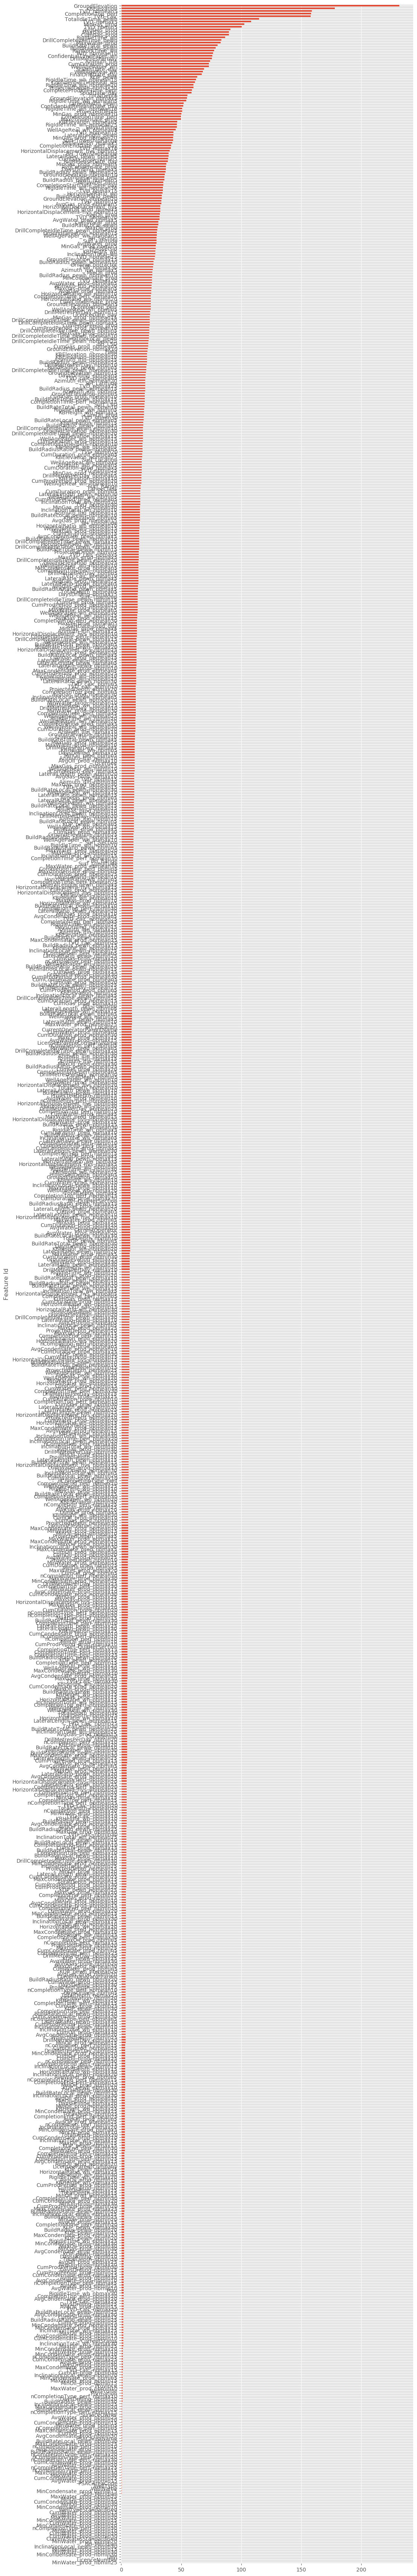

In [32]:
plt.figure(figsize=(10,90))
feat_im.set_index('Feature Id').mean(axis=1).sort_values(ascending=True).plot(kind='barh')

## Joining

In [33]:
trainid = alldata.loc[(alldata.TVD.isnull()==False)&(alldata.Formation!='Cardium'), ['EPAssetsId']]
testid = alldata.loc[(alldata.TVD.isnull())&(alldata.Formation!='Cardium'), ['EPAssetsId']]

In [34]:
y_tr = trainid.copy(deep=True)
y_tr = y_tr.merge(y_trSWS, on='EPAssetsId', how='left')
y_tr = y_tr.merge(y_trWWS, on='EPAssetsId', how='left')
y_tr['pred_x'] = y_tr.pred_x.fillna(y_tr.pred_y)
y_tr.drop(['pred_y'], axis=1, inplace=True)
y_tr.rename(columns={'pred_x': 'pred'}, inplace=True)

In [35]:
y_pred = testid.copy(deep=True)
y_pred = y_pred.merge(y_predSWS, on='EPAssetsId', how='left')
y_pred = y_pred.merge(y_predWWS, on='EPAssetsId', how='left')
y_pred['pred_x'] = y_pred.pred_x.fillna(y_pred.pred_y)
y_pred.drop(['pred_y'], axis=1, inplace=True)
y_pred.rename(columns={'pred_x': 'pred'}, inplace=True)

## Submission

In [65]:
path = '../'
sub_sam = pd.read_csv(path+'Submission_Sample.csv')
sub_sam = sub_sam.drop('TVD', axis=1)
sub_sam

,EPAssetsId
0,1161143
1,2597084
2,1164793
3,1170291
4,2603236
...,...
1958,1159695
1959,2612450
1960,2607916
1961,2602544


In [66]:
sub_sam.merge(y_pred, on='EPAssetsId', how='left')

,EPAssetsId,pred
0,1161143,728.902580
1,2597084,2935.180744
2,1164793,696.835603
3,1170291,683.626732
4,2603236,2227.761648
...,...,...
1958,1159695,734.933645
1959,2612450,3089.804798
1960,2607916,2306.196457
1961,2602544,859.034603


In [67]:
sub = sub_sam.merge(y_pred, on='EPAssetsId', how='left')
sub.rename(columns={'pred': 'TVD'}, inplace=True)

In [68]:
# change filename
# sub.to_csv('xxx.csv', index=False)